In [54]:
import os
import torch
import datetime
import json
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

from torchvision.datasets.coco import CocoDetection

In [77]:
from constants import path_to_data, num_images
from show import *

In [78]:
from torchvision import transforms as T

# From mask to COCO (WIP)

In [79]:
to_pil = T.ToPILImage()

In [50]:
import cv2

In [9]:
img_res_paths = [['{}/images/rot_aug_1024/{}_{:03d}_000.torch'.format(path_to_data, n, idx) for n in ['img', 'lbl']] for idx in range(num_images)]

In [39]:
img, lbl = img_res_paths[0]
img, lbl = torch.load(img), torch.load(lbl)

lbl.unique()

tensor([2, 1, 0], dtype=torch.int32)

(683, 1024, 3) (683, 1024, 1)


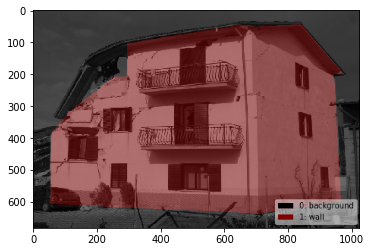

In [58]:
show_labeled_img(img, lbl > 0)

In [85]:
plant_book_mask_image = to_pil(lbl > 0)#Image.open('/path/to/images/plant_book_mask.png')
bottle_book_mask_image = to_pil(lbl == 1)#Image.open('/path/to/images/bottle_book_mask.png')

In [86]:
from PIL import Image # (pip install Pillow)

def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))

            # If the pixel is not black...
            if pixel != 0:
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks


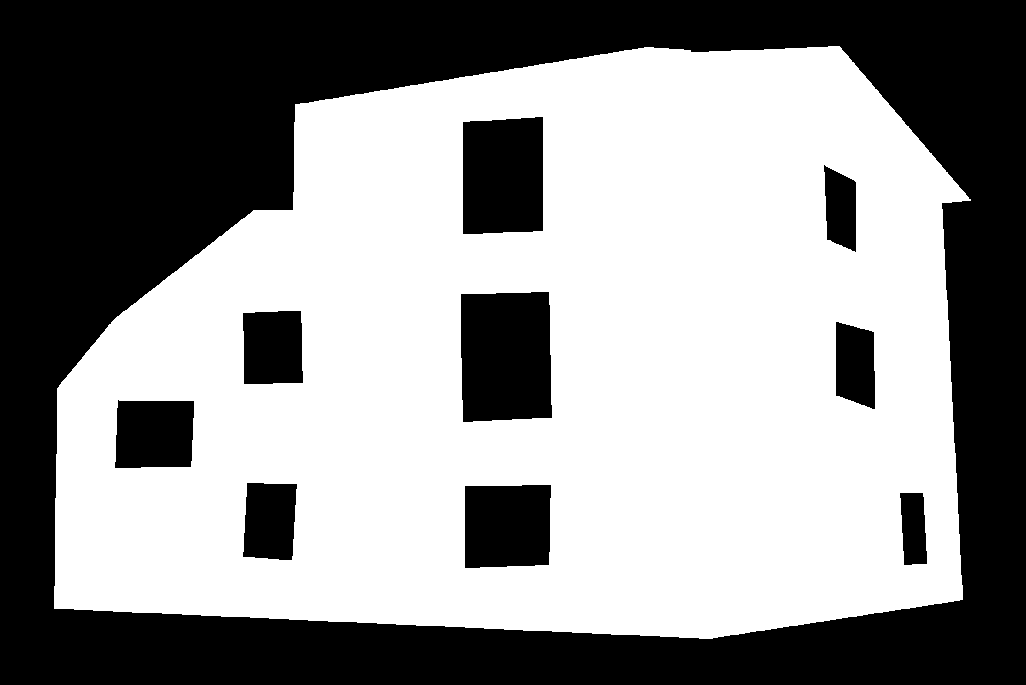

In [90]:
create_sub_masks(to_pil(lbl))['1']

In [82]:
import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation

In [81]:
import json


mask_images = [plant_book_mask_image, bottle_book_mask_image]

# Define which colors match which categories in the images
houseplant_id, book_id, bottle_id, lamp_id = [1, 2, 3, 4]
category_ids = {
    1: {
        '(0, 255, 0)': houseplant_id,
        '(0, 0, 255)': book_id,
    },
    2: {
        '(255, 255, 0)': bottle_id,
        '(255, 0, 128)': book_id,
        '(255, 100, 0)': lamp_id,
    }
}

is_crowd = 0

# These ids will be automatically increased as we go
annotation_id = 1
image_id = 1

# Create the annotations
annotations = []
for mask_image in mask_images:
    sub_masks = create_sub_masks(mask_image)
    for color, sub_mask in sub_masks.items():
        category_id = category_ids[image_id][color]
        annotation = create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd)
        annotations.append(annotation)
        annotation_id += 1
    image_id += 1

print(json.dumps(annotations))

TypeError: 'int' object is not subscriptable